# Step 1 Box plot  (distribution #comments/each post among different facebook fans pages)

In [1]:
%matplotlib inline

import pyes
import json
import pandas as pd
import seaborn as sns

def boxPlotFBFansPageComp(fids,host,pngFilePath,outlierFilter):
    data=[]
    for fid in fids:
        conn = pyes.es.ES(host)
        tq = pyes.query.TermQuery(field="fid", value=fid)
        tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
        qsearch = pyes.query.Search(tq) 
        qsearch.agg.add(tagg) 
        result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment')
        #print json.dumps(result.aggs,indent=2) 
        for fidpid_summary in result.aggs["pid"]["buckets"]:
            #print fidpid_summary["key"] + ',' + str(fidpid_summary["doc_count"])
            if fidpid_summary["doc_count"] < outlierFilter or outlierFilter < 0:
                data.append([fidpid_summary["doc_count"],fid,fidpid_summary["key"]])

    df=pd.DataFrame(data,columns={'count','fid','fidpid'})
    sns.set(style="ticks")
    sns_plot=sns.boxplot(x="fid", y="count", data=df, palette="PRGn")
    fig=sns_plot.get_figure()
    fig.savefig(pngFilePath)

# Step 2: Please assign several Facebook fan pages and parameters 

## (code-customerized by yourself is required!)


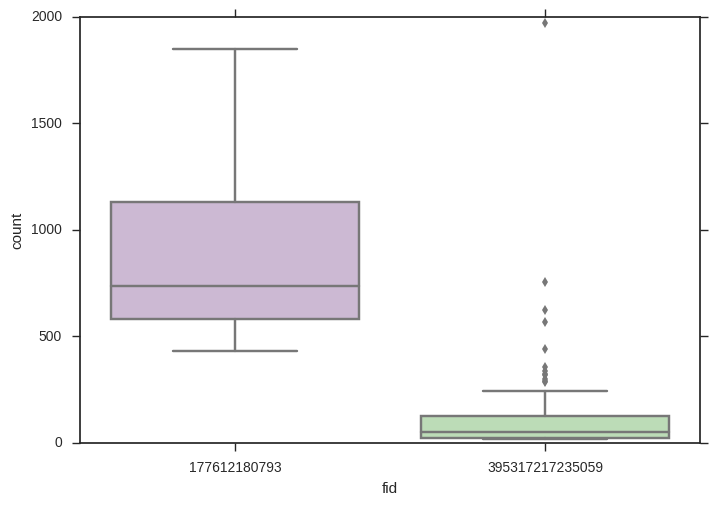

In [2]:
#assign the facebook fans page that you prefered
fids=['395317217235059','177612180793']

#elasticsearch repository provided by this course
host = '140.118.175.209:9200'

#output box plot PNG figure
pngFilePath="output.png"

#outlier threshold you want to filter (if you give minus ONE, none of outlier is filtered.)
outlierFilter=2000

#obtain the result and save as "pngFilePath" given from you
boxPlotFBFansPageComp(fids,host,pngFilePath,outlierFilter)

# Step 3: Box plot (#post per month for specified page)¶

In [3]:
import pyes
import json
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt


def boxPlotNumofPostPerMonth(fid,host,lowerbound,upperbound,pngFilePath):
    conn = pyes.es.ES(host)
    tq = pyes.query.TermQuery(field="fid", value=fid)
    #tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
    DHAgg = pyes.aggs.DateHistogramAgg('month' ,field='created_time', interval='month',sub_aggs=[])
    tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
    DHAgg.sub_aggs.append(tagg) 
    qsearch = pyes.query.Search(tq) 
    qsearch.agg.add(DHAgg) 
    result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment')

    data=[]
    for r in result.aggs["month"]["buckets"]:
        for pid in r["pid"]["buckets"]:
            monthyear=datetime.datetime.strptime(r["key_as_string"], "%Y-%m-%dT%H:%M:%S.%fZ").strftime('%Y/%m')
            data.append([pid["doc_count"],monthyear,pid["key"],r["key"]])

    df=pd.DataFrame(data,columns={'date','count','fid','pid'})
    sns.set(style="ticks")
    sns_plot=sns.boxplot(x="date", y="count", data=df, palette="PRGn")
    fig=sns_plot.get_figure()
    plt.ylim(lower_bound, upper_bound)
    fig.savefig(pngFilePath)

# Step 4: Please assign several Facebook fan pages and parameters
(code-customerized by yourself is required!)

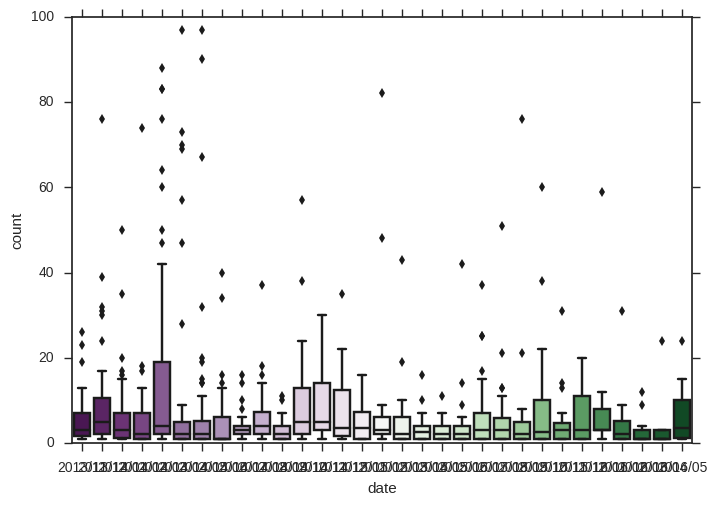

In [4]:
host = '140.118.175.209:9200'
lower_bound = 0
upper_bound = 100
fid="395317217235059"
pngFilePath="output3.png"
boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound,pngFilePath)

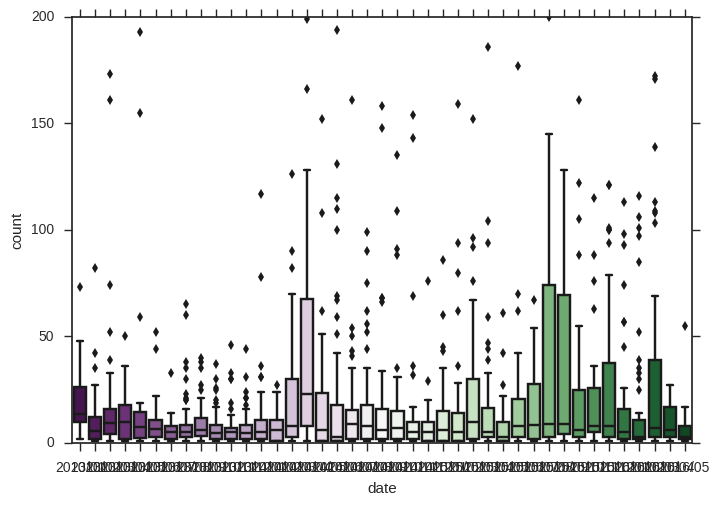

In [5]:
host = '140.118.175.209:9200'
lower_bound = 0
upper_bound = 200
fid="177612180793"
pngFilePath="output4.png"
boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound,pngFilePath)

In [6]:
# host = '140.118.175.209:9200'
# lower_bound = 0
# upper_bound = 500
# fid="179080912217031"
# pngFilePath="output5.png"
# boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound,pngFilePath)

# Step 5 Get User-Post frequence matrix
## input {es address, row name, column name, fans page ID}

In [7]:
import pyes
import json

def getUserPostFreqMatrix(es_address,row,column,fid):
    rc=200
    cc=200
    
    rowIndexList,colIndexList,matrix = [],[],[]
    conn=pyes.es.ES(es_address)
    tq = pyes.query.TermQuery(field="fid", value=fid)

    tagg = pyes.aggs.TermsAgg(row, field= r, sub_aggs=[]) 
    tagg1 = pyes.aggs.TermsAgg(column, field= c)  
    tagg.sub_aggs.append(tagg1) 

    qsearch = pyes.query.Search(tq) 
    qsearch.agg.add(tagg)

    rs = conn.search(query=qsearch, indices='facebook_nested' ,type="comment" )
    
    rowcount=0
    colcount=0
    for user in rs.aggs[row]['buckets']:
        if user['key']!="" and user['key'] not in rowIndexList and rowcount<rc:
            rowIndexList.append(user['key'])
            rowcount=rowcount+1

        for post in user[column]['buckets']:
            if post['key'] not in colIndexList and colcount<cc:
                colIndexList.append(post['key'])
                colcount=colcount+1

    for i in range(0,len(rowIndexList)):
        matrix.append([0.0]*len(colIndexList))

    for user in rs.aggs[row]['buckets']:
        if user["key"] in rowIndexList:
            for post in user[column]['buckets']:
                if post['key'] in colIndexList:
                    matrix[rowIndexList.index(user['key'])][colIndexList.index(post['key'])]= float(post['doc_count'])
    
    
    return {"data":matrix,"col":colIndexList,"row":rowIndexList}

# Step 6: Please assign specified Facebook fan page and parameters

In [8]:
es_address="140.118.175.209:9200"
r="from.id"
c="fid_pid"
fid="395317217235059"
result = getUserPostFreqMatrix(es_address,r,c,fid)

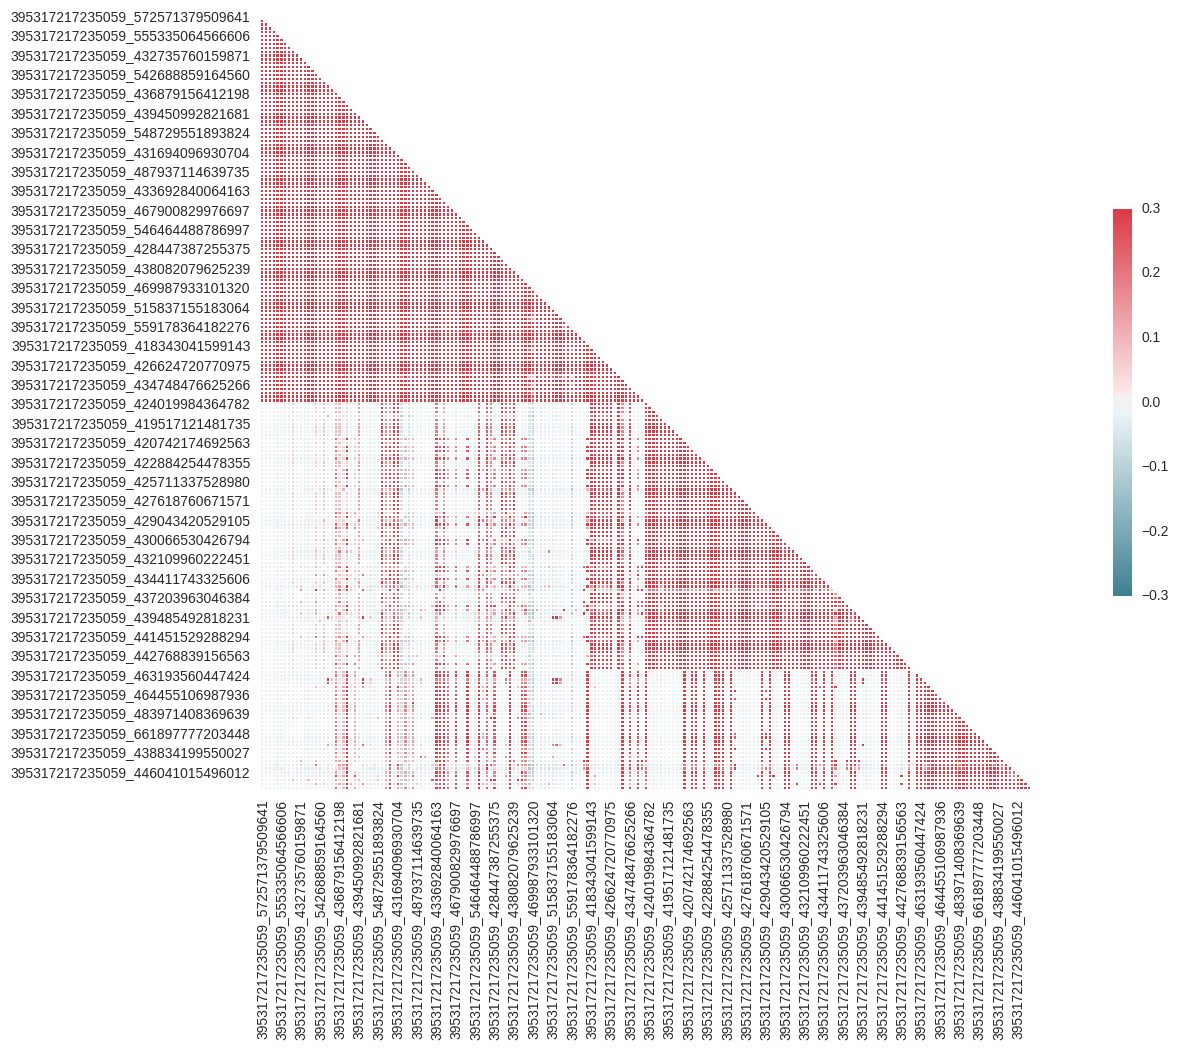

In [9]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
d = pd.DataFrame(data=result["data"],
                 columns=result["col"])

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [10]:
result["row"]

[u'395317217235059',
 u'796564960430912',
 u'10208454821393542',
 u'392695967601138',
 u'752666538172061',
 u'1273732699310988',
 u'924033527636457',
 u'985811768156527',
 u'10204758656477168',
 u'935163973188093',
 u'1748008755426871',
 u'893564694072566',
 u'580113768813264',
 u'674013206068779',
 u'951165924973332',
 u'1083002335073365',
 u'1694167814171824',
 u'935785553169974',
 u'1203901982957461',
 u'1151442484868666',
 u'751728608292593',
 u'10201271490665235',
 u'1566905253563785',
 u'1671132899803788',
 u'715698031897797',
 u'745489168917405',
 u'982586895147651',
 u'1235038223178720',
 u'762274820572651',
 u'10205564503047941',
 u'556718424477308',
 u'1056397857715266',
 u'1158933254124701',
 u'1246669388693211',
 u'10205466280926338',
 u'1076269912425519',
 u'739103976225105',
 u'10204062966612744',
 u'1022700747787464',
 u'1054779751238835',
 u'415466271995882',
 u'1560512890905077',
 u'1640396159542938',
 u'940633109363110',
 u'10207034280268941',
 u'10207741721128584',
 